Covid-19_and_Pneumonia_X-Ray_Detector

In [1]:
# Connect Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, cohen_kappa_score, recall_score, f1_score

In [4]:
import cv2
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import InverseTimeDecay

In [6]:
# Load, scale and prepare train sets
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
from tensorflow.keras import regularizers

In [8]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import tensorflow_addons as tfa
from tensorflow_addons.metrics import CohenKappa
# from tensorflow_addons.losses import WeightedKappaLoss # ??? Ordinal?

In [10]:
# resNet50
# from tensorflow.keras.applications.resnet50 import ResNet50
# ModuleNotFoundError: No module named 'tensorflow.keras.application'

# Functions

In [11]:
def listdir_nohidden(path):
  """ returns a list of no hidden folders in a path
  in this case the folders are sorted as the are classes of a images
  (and later will be used as an iterator...)"""
  # import os

  folders = []
  for f in os.listdir(path):
    if not f.startswith('.'):
      # yield f # returns a generator (iterable)
      folders += [f]
  return sorted(folders)


In [12]:
def plot_metric(history, metric):
    train_metrics = history.history[metric] # Get the error metric for the TRAIN set
    val_metrics = history.history['val_'+metric] # Get the error metric for the VALIDATION set
    epochs = range(1, len(train_metrics) + 1) # range(1,6) -> 1,2,3,4,5
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.yscale('log')
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

# Description

### Identify COVID by x-RAy  
Dectect and classify chest illneses.  
Reduce costs and detection time.  
Have a pre-diagnosis in minutes. Increase survival rate.  
Categories:  
* Healthy
* Covid-19
* Bacterial Pneumonia
* Viric Pneumonia   


### Data info
custom dataset that contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray iamges and normal person x-ray images.Each class contains 133 images.  
  
data from https://github.com/ieee8023/covid-chestxray-dataset and https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia.  
created by frogames.    

0 - Covid-19

1 - Normal X-ray

2 - Viral Pneumonia X-ray

3 - Bacterial Pneumonia X-ray


# Load Data

In [13]:
# !!! change dir
# allows to work with relative paths in all the notebook
os.chdir('/content/drive/MyDrive/ironhack-finalProject')

In [14]:
train_path = 'data_train'

In [15]:
# Scan folders in train_path
# os.listdir(train_path)
listdir_nohidden(train_path)

['0', '1', '2', '3']

In [16]:
datagen_load = ImageDataGenerator(rescale = 1./255,
                                     validation_split = 0.2)

In [17]:
# Question 
# ??? rescale --> I think it min_max_scale the values of the pixels in the image
# between 0 and 1


In [18]:
load_generator = datagen_load.flow_from_directory(batch_size = 40,
                                                      directory = train_path,
                                                      seed = 0,
                                                      target_size = (256,256), # input size to the NN
                                                      # classes = ['covid', 'normal', 'viral', 'bacteria'],
                                                      class_mode = "categorical",
                                                      subset = "training")

Found 428 images belonging to 4 classes.


In [19]:
# Question
# !!! flow_from_directory Deprecated?
# classes?

Deprecated: tf.keras.preprocessing.image.ImageDataGenerator is not recommended for new code. Prefer loading images with tf.keras.utils.image_dataset_from_directory and transforming the output tf.data.Dataset with preprocessing layers. For more information, see the tutorials for loading images and augmenting images, as well as the preprocessing layer guide.  
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory

In [20]:
# test_path = '/content/drive/MyDrive/ironhack-finalProject/data_test'

In [21]:
# Define validation subset
# After validation split en image_generator
load_validation = datagen_load.flow_from_directory(batch_size = 40,
                                                      directory = train_path,
                                                      seed = 0,
                                                      target_size = (256,256), # input size to the NN
                                                      # classes = ['covid', 'normal', 'viral', 'bacteria'],
                                                      class_mode = "categorical",
                                                      subset = "validation")


Found 104 images belonging to 4 classes.


In [22]:
# 133*4, 133*4*0.8, 133*4*0.2

In [23]:
train_images, train_labels = next(load_generator)

In [24]:
# Question
# ??? next?
# https://datascience.stackexchange.com/questions/88737/keras-next-what-does-2-256-128-128-3-mean

In [25]:
# train_generator.shape

In [26]:
train_images.shape

(40, 256, 256, 3)

In [27]:
train_labels.shape

(40, 4)

In [28]:
train_labels

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]],

In [29]:
# We are assuming that is not possible to have two illneses at the same time

In [30]:
label_names = {0:'covid', 1:'normal', 2: 'viral', 3:'bacterial'}

# Visualize images

In [31]:
#L = 6
#W = 6
#range(L*W)

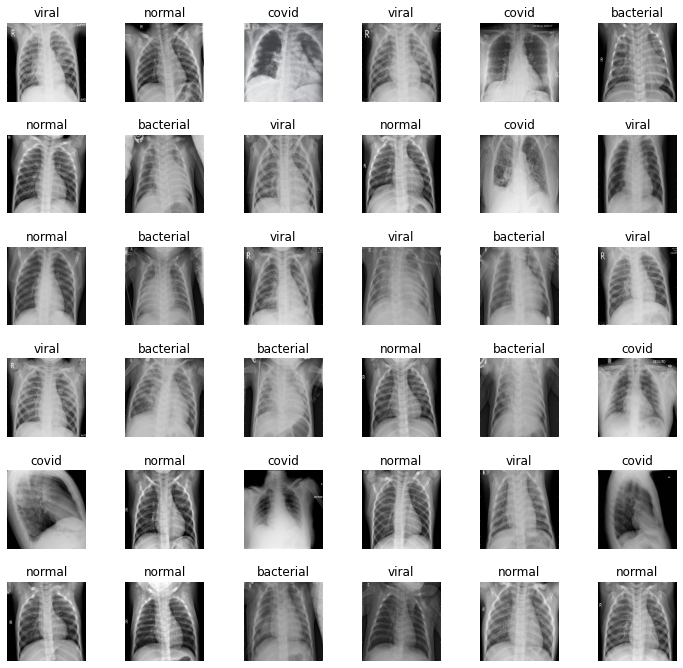

In [32]:
# Create matrix of images
L = 6
W = 6

fig, ax = plt.subplots(L, W, figsize = (12,12))
ax = ax.ravel() # it flattens the axes and allows to make a for loop

for i in range(L*W):
  ax[i].imshow(train_images[i])
  ax[i].set_title(label_names[np.argmax(train_labels[i])])
  ax[i].axis('off')

plt.subplots_adjust(wspace=0.5)

In [33]:
# 120*5*5

# Build the CNN 0

## Convolutional architecture

In [34]:
# Initialize the CNN
cls = Sequential()

In [35]:
# Add Convolution Layer
# cls.add(Conv2D(32, (5,5), input_shape= (256,256,3), activation='relu', padding = 'valid' ))
cls.add(Conv2D(9, (5,5), input_shape= (256,256,3), activation='relu', padding = 'valid' ))

In [36]:
# classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
# input shape necessary when not all the pictures are squared.

In [37]:
# Question
# ??? padding, --> acolchado/ relleno en el input. if padding "same" and strides = 1
# then input size and output size will be the same
# ??? strides, --> zancadas o avances. i.e [i,2,2,1] (if window 2x2 no overlaping)
# ??? dilation_rate...

In [38]:
# Add Max Pooling (spatial subsampling)
# Very important define well the pool_size
cls.add(MaxPool2D(pool_size = (2, 2), padding="valid"))
cls.add(MaxPool2D(pool_size = (2, 2), padding="valid"))

In [39]:
# average pooling 
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D

In [40]:
# Flattening
cls.add(Flatten())

## Fully-connected layers

In [41]:
# Dense Layers
#cls.add(Dense(units = 256, activation = 'relu'))
#cls.add(Dense(units = 128, activation = 'relu'))
cls.add(Dense(units = 64, activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))


In [42]:
# Dropout Layers
cls.add(Dropout(0.2, seed = 0))

In [43]:
# Classification Layer
cls.add(Dense(units = 4, activation = 'softmax'))

In [44]:
# 84/120

In [45]:
# ??? How long is the flaten layer?
# units --> positive integer, dimensionality of the output space

In [46]:
# 256*2

## Save model Weights0 - no compiled

In [47]:
cls.save('models/xRay_aug_regu_w0.hdf5')

## Compile CNN

In [48]:
# Compilation and generation parameters
batchSize = 4 # train_generator.batch_size
train_len = 532  # train_generator.n
# epochs = 30
stepsEpoch = train_len//batchSize
stepsEpoch

133

### Laerning Rate Scheduler

In [49]:
"""
# Define Scheduler
lr_scheduler = InverseTimeDecay(0.0012,
                                decay_steps= 1.2*stepsEpoch,
                                decay_rate = 0.1)

def get_optimizer():
  return Adam(lr_scheduler)
"""

'\n# Define Scheduler\nlr_scheduler = InverseTimeDecay(0.0012,\n                                decay_steps= 1.2*stepsEpoch,\n                                decay_rate = 0.1)\n\ndef get_optimizer():\n  return Adam(lr_scheduler)\n'

In [50]:
"""
# Check Scheduler
step = np.linspace(0,3500)
lr = lr_scheduler(step)
plt.figure(figsize = (8,6))
plt.plot(step/stepsEpoch, lr)
# plt.hlines(0.001, xmin=0, xmax=)
plt.axhline(0.001, c='k', ls = '-', lw = 0.6)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')
"""

"\n# Check Scheduler\nstep = np.linspace(0,3500)\nlr = lr_scheduler(step)\nplt.figure(figsize = (8,6))\nplt.plot(step/stepsEpoch, lr)\n# plt.hlines(0.001, xmin=0, xmax=)\nplt.axhline(0.001, c='k', ls = '-', lw = 0.6)\nplt.ylim([0,max(plt.ylim())])\nplt.xlabel('Epoch')\n_ = plt.ylabel('Learning Rate')\n"

In [55]:
# len(step)

In [56]:
optimizer = Adam(learning_rate=0.001) # get_optimizer()

In [57]:
cls.compile(optimizer = optimizer, loss = 'categorical_crossentropy', # 'adam'
            metrics=['accuracy','Precision','Recall',CohenKappa(num_classes=4)])
# tf.keras.losses.CategoricalCrossentropy(name = 'categorical_crossentropy')

In [58]:
# Question
# compile --> monta la estructura y el optimizador
# el optimizador busca los mejores pesos para conseguir que la función de loss 
# sea lo más pequeña posible. Y la función de loss depende las funciones de activacion



In [59]:
#cls.summary()

In [60]:
cls.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 9)       684       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 9)      0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 9)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 35721)             0         
                                                                 
 dense (Dense)               (None, 64)                2286208   
                                                                 
 dropout (Dropout)           (None, 64)                0

## define kappa loss

In [61]:
# kappa_loss = CohenKappa(num_classes=4) #, )

## define callbacks

In [62]:
# Define callbacks

In [63]:
checkpoint_path = 'models/xRay-aug_regu_lrSch.hdf5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor = 'val_cohen_kappa', # !!! # 'val_loss'
    mode = 'max', # !!! necessary if save_best_only = True
    save_freq='epoch', # How often the checkpoint file will be saved.
    save_weights_only=False, # Wether or not to save just the weitgths of each neuron.
    save_best_only = True, 
    # it only saves when the model is considered the "best" and the latest 
    # best model according to the quantity monitored will not be overwritten
    verbose=1 # To display the progress
)

In [64]:
early_stopping = EarlyStopping(monitor = "val_cohen_kappa", mode = 'max', #, kappa_metric, 
                               patience=10, verbose=1) 


# Train and validation generator.  
??? Different batch size.  


In [65]:
img_generator_train = ImageDataGenerator(rescale = 1./255,
                                         rotation_range = 20,
                                         shear_range = 0.2,
                                         zoom_range = 0.3,
                                         horizontal_flip = True) #,
                                         #validation_split = 0.2)
                                         

img_generator_val = ImageDataGenerator(rescale = 1./255) #validation_split = 0.2)

In [66]:
# generate the train and test with different batch size
train_generator = img_generator_train.flow_from_directory(batch_size = batchSize,
                                                      directory = train_path,
                                                      seed = 0,
                                                      shuffle = True,
                                                      target_size = (256,256), # input size to the NN
                                                      # classes = ['covid', 'normal', 'viral', 'bacteria'],
                                                      class_mode = "categorical")#,
                                                      #subset = "training")

Found 532 images belonging to 4 classes.


In [67]:
val_generator = img_generator_val.flow_from_directory(batch_size = batchSize,
                                                      directory = train_path,
                                                      seed = 0,
                                                      shuffle = True,
                                                      target_size = (256,256), # input size to the NN
                                                      # classes = ['covid', 'normal', 'viral', 'bacteria'],
                                                      class_mode = "categorical")#,
                                                      #subset = "validation")

Found 532 images belonging to 4 classes.


In [68]:
train_generator.n

532

In [69]:
train_generator.batch_size

4

# fit_generator train_data

In [70]:
history = cls.fit_generator(
    train_generator, 
    validation_data=val_generator,
    steps_per_epoch= train_generator.n//4,
    epochs=35, # Number of epochs. 
    #validation_split=0.20, # Here the TRAIN set will be split in TRAIN = TRAIN_NEW + VALIDATION. TRAIN_NEW used 
    # for train and val for CV
    #batch_size=20, # How many samples to input in the network before updating the weights
    #verbose=2, # To display the progress.
    callbacks=[early_stopping,checkpoint]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/35
133/133 [==============================] - ETA: 0s - loss: 1.9340 - accuracy: 0.3872 - precision: 0.4261 - recall: 0.0921 - cohen_kappa: 0.1830
Epoch 1: val_cohen_kappa improved from -inf to 0.45614, saving model to models/xRay-aug_regu_lrSch.hdf5
133/133 [==============================] - 52s 380ms/step - loss: 1.9340 - accuracy: 0.3872 - precision: 0.4261 - recall: 0.0921 - cohen_kappa: 0.1830 - val_loss: 1.2003 - val_accuracy: 0.5921 - val_precision: 0.7593 - val_recall: 0.1541 - val_cohen_kappa: 0.4561
Epoch 2/35
133/133 [==============================] - ETA: 0s - loss: 1.1901 - accuracy: 0.5658 - precision: 0.7059 - recall: 0.2256 - cohen_kappa: 0.4211
Epoch 2: val_cohen_kappa improved from 0.45614 to 0.68421, saving model to models/xRay-aug_regu_lrSch.hdf5
133/133 [==============================] - 50s 372ms/step - loss: 1.1901 - accuracy: 0.5658 - precision: 0.7059 - recall: 0.2256 - cohen_kappa: 0.4211 - val_loss: 0.8607 - val_accuracy: 0.7632 - val_precision: 0.845

In [71]:
# Steps per epoch: images in data_train (train_generator) / batch size

In [95]:
history

In [97]:
history.model

In [98]:
type(history.history)

dict

In [72]:
print(history.params)

{'verbose': 1, 'epochs': 35, 'steps': 133}


In [73]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'cohen_kappa', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_cohen_kappa'])


# Evaluate Model Training


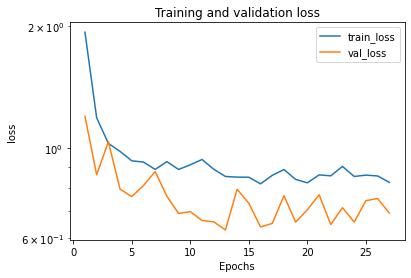

In [89]:
plot_metric(history, 'loss')

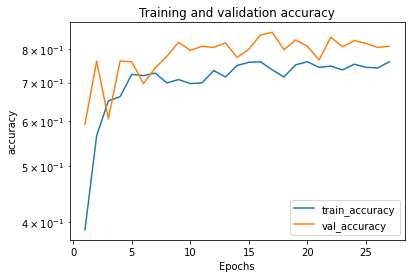

In [ ]:
plot_metric(history, 'accuracy')

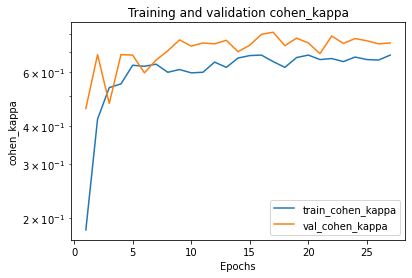

In [75]:
plot_metric(history, 'cohen_kappa')

# Evaluate Train

In [90]:
eval_train = cls.evaluate_generator(load_validation, 
                                  steps = load_validation.n//4,
                                  verbose = 1)

print('Accuracy in train: {}'.format(eval_train[1]))
print('Kappa in train: {}'.format(eval_train[-1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


26/26 [==============================] - 3s 60ms/step - loss: 0.6236 - accuracy: 0.8077 - precision: 0.8384 - recall: 0.7981 - cohen_kappa: 0.7436
Accuracy in test: 0.807692289352417


In [91]:
list(zip(cls.metrics_names,eval_train))

[('loss', 0.6235526204109192),
 ('accuracy', 0.807692289352417),
 ('precision', 0.8383838534355164),
 ('recall', 0.7980769276618958),
 ('cohen_kappa', 0.7435897588729858)]

# Generate Test Set

In [76]:
test_path = 'data_test'

In [77]:
test_gen = ImageDataGenerator(rescale = 1./255)

In [78]:
test_generator = test_gen.flow_from_directory(directory=test_path,
                                              target_size = (256,256),
                                              class_mode = "categorical",
                                              batch_size=4,
                                              shuffle=True,
                                              seed = 0,
                                              )

Found 40 images belonging to 4 classes.


# Evaluate Test

In [101]:
eval_test = cls.evaluate_generator(test_generator, 
                                  steps = test_generator.n//4,
                                  verbose = 1)

print('Accuracy in test: {}'.format(eval_test[1]))
print('Kappa in test: {}'.format(eval_test[-1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


10/10 [==============================] - 1s 135ms/step - loss: 0.9186 - accuracy: 0.8000 - precision: 0.8205 - recall: 0.8000 - cohen_kappa: 0.7333
Accuracy in test: 0.800000011920929
Kappa in test: 0.7333333492279053


In [94]:
list(zip(cls.metrics_names,eval_train))

[('loss', 0.6235526204109192),
 ('accuracy', 0.807692289352417),
 ('precision', 0.8383838534355164),
 ('recall', 0.7980769276618958),
 ('cohen_kappa', 0.7435897588729858)]

# Prediction

In [81]:
# from sklearn.metrics import...

prediction = []
original = []
image = []
items = []

for i in range(len(listdir_nohidden(test_path))):
  for item in os.listdir(os.path.join(test_path, str(i))):
    items.append(item)
    img = cv2.imread(os.path.join(test_path, str(i), item))
    img = cv2.resize(img, (256,256))
    image.append(img)
    img = img/255 # manually scale between 0 and 1
    img = img.reshape(-1, 256, 256, 3) # our CNN was trained with batchs
    predict = cls.predict(img) # just predict 
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

results = pd.DataFrame({'image':items, 'category':original, 'prediction':prediction})

In [82]:
len(original)

40

In [83]:
#len(listdir_nohidden(test_path))

In [84]:
score = accuracy_score(original, prediction)
print('Accuracy on prediction: {}'.format(score))

Accuracy on prediction: 0.8


In [85]:
kappa_pred = cohen_kappa_score(original, prediction)
print('Kappa on prediction: {}'.format(kappa_pred))

Kappa on prediction: 0.7333333333333334


# Confusion Matrix Test

In [86]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       1.00      0.80      0.89        10
           2       0.62      0.80      0.70        10
           3       0.78      0.70      0.74        10

    accuracy                           0.80        40
   macro avg       0.82      0.80      0.81        40
weighted avg       0.82      0.80      0.81        40



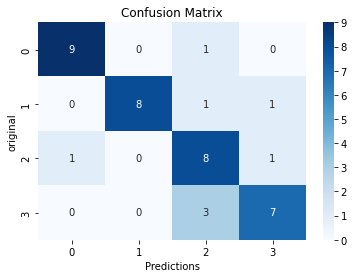

In [87]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap='Blues')
ax.set_xlabel('Predictions')
ax.set_ylabel('original')
ax.set_title('Confusion Matrix')
plt.show()

# Results

In [88]:
results[results.category != results.prediction][(results.prediction == 1) & (results.category == 3)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,image,category,prediction
